**IMPORT LIBS**

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras.backend as K

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

**Create aux folders and get file path**

In [2]:
# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, os.pardir))

datasetUAH_dir = os.path.join(root_dir, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {root_dir}')
print(f'Dataset directory: {datasetUAH_dir}')

Root directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification
Dataset directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification\datasets\UAH-DRIVESET-v1\UAH-Processed


# **AUX FUNCTIONS**

In [3]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **DATA PREPROCESSING**

## **Data structure:**

- Acceleration (m/s2): X, Y, Z Axis 

- Gyroscope (°/s): X, Y, Z Axis

- GPS: Latitude and Longitude 

In [4]:
dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v2', 'dataset-all.csv')
# dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v1', 'Abrantes-Leiria.csv')

# Load the dataset into a DataFrame
df = pd.read_csv(dataset)

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [5]:
# print(df['accelerometerXAxis'].describe())
# print(df['accelerometerYAxis'].describe())
# print(df['accelerometerZAxis'].describe())
# print(df['gyroscopeXAxis'].describe())
# print(df['gyroscopeYAxis'].describe())
# print(df['gyroscopeZAxis'].describe())

## **Separate data by maneuver**

We identify different manovers based on the **Acceleration and Gyroscope data**.

Accelerometer:
- X - Curves
- Y - Acceleration and braking
- Z - Vertical acceleration - Uphill and downhill

Gyroscope:
- X - Longitudinal tilt - Uphill and downhill
- Y - Lateral tilt
- Z - Curves

In [6]:
# Curves
turnRightX, turnLeftX = separate_positives_negatives(acelX)
# Acceleration and breaking
accelY, breakY = separate_positives_negatives(acelY)
# Vertical acceleration - hills and bumps
positiveZ, negativeZ = separate_positives_negatives(acelZ)

# Longitudinal tilt - hills and bumps
gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
# Lateral tilt
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
# Curves
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)


turnRightX.shape

(150070,)

# **Normalize Data**

We normalize the data to guarantee a consistent representation of the data and a better performance of the model.

The normalization in done in the following way:
- Identify the maximum absolute value of the combined three axis of the accelerometer and gyroscope
- Normalize the values between 0 and max value

In [7]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

## Array with all the data

In [8]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

x.shape

(150070, 12)

## **Labelling Data**

The labelling is done considering:
- The **Max value** of each column
- An **Adjustable threshold** between 0 and 1.

The product of this maximum value and the threshold establishes a reference point that indicates the intensity of the maneuver.

- If the data value is greater than or equal to the reference point, it will be classified as 1 (aggressive).

- If the data value is less than the reference point, it will be classified as 0 (non-aggressive).

In [9]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

filename = 'runtime_saves/' + 'Y.csv'
print(y)

np.savetxt(filename, y, delimiter=',', fmt='%.0i')

[ 789 2127  408  247  896  191   45   30   10  142   88    6]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Show manovers on Google Map

In [10]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

## Plot manovers

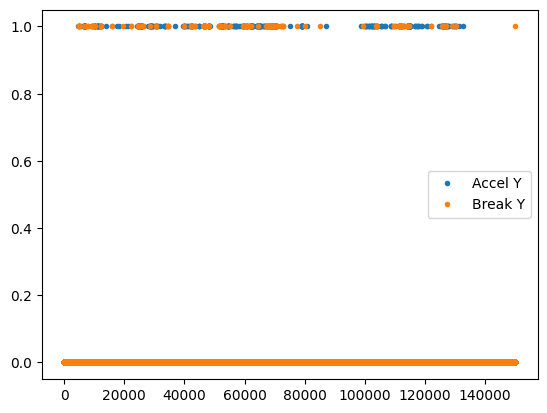

In [11]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **MODEL**

## Separate data in train and test

In [12]:
# x_train, x_test = split_train_test(x, test_size=0.2)

# y_train, y_test = split_train_test(y, test_size=0.2)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(112552, 12) (112552, 12)
(37518, 12) (37518, 12)


## Create the input tensor data

In [13]:
train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

print(train.shape)
print(test.shape)

# np.savetxt("runtime_saves/train&test/x_train.csv", x_train, delimiter=',', fmt='%.9f')
# np.savetxt("runtime_saves/train&test/x_test.csv", x_test, delimiter=',', fmt='%.9f')
# np.savetxt("runtime_saves/train&test/y_train.csv", y_train, delimiter=',', fmt='%.0i')
# np.savetxt("runtime_saves/train&test/y_test.csv", y_test, delimiter=',', fmt='%.0i')

# np.savetxt("runtime_saves/train&test/train.csv", train.reshape(train.shape[0], train.shape[2]), delimiter=',', fmt='%.9f')
# np.savetxt("runtime_saves/train&test/test.csv", test.reshape(test.shape[0], test.shape[2]), delimiter=',', fmt='%.9f')

(112552, 1, 12)
(37518, 1, 12)


## **Create Model**

LSTM model with 2 LSTM layers and 2 Dense layers.
-    Input shape: (n_timesteps, n_features)
-    LSTM layers with Dropout for regularization
-    Output layer with sigmoid activation function for binary classification
-    Binary Crossentropy loss function because it is a binary classification problem

In [14]:
# K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, train.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))


model_lstm.add(Dense(y_train.shape[1],activation='sigmoid'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## **Train Model**

Train the model with the training data and validate it with the test data.

Training configuration:
- 30 epochs
- Batch size of 64
- Early stopping to prevent overfitting
- Learning rate reduction on plateau
- Model checkpoint to save the best model based on validation loss

In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.0000)
model_checkpoint = ModelCheckpoint('best_models/best_model_StackedLSTM.keras', monitor='val_loss', save_best_only=True)



# Train the model
model_lstm_output = model_lstm.fit(train, y_train, epochs=30,  batch_size=64, callbacks=[early_stopping,model_checkpoint,reduce_lr], validation_data=(test, y_test))

Epoch 1/30
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0109 - loss: 0.1488 - val_accuracy: 0.0144 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 2/30
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0336 - loss: 0.0131 - val_accuracy: 0.0144 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 3/30
 823/1759 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0247 - loss: 0.0111

KeyboardInterrupt: 

# **RESULTS**

## Evaluate the model

In [ ]:
pred = model_lstm.predict(test)
print(pred)

1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[[1.2103292e-09 5.2707257e-12 6.5376513e-09 ... 5.1163158e-07
  1.0833223e-07 4.1506235e-10]
 [1.6006819e-09 1.0744818e-11 9.5600129e-08 ... 1.7746441e-07
  6.8750708e-08 2.3827479e-10]
 [1.4900549e-04 1.9886409e-07 4.5758736e-04 ... 7.5388071e-04
  7.1137470e-01 1.0479895e-03]
 ...
 [3.1162420e-10 2.2728163e-12 2.7728022e-09 ... 3.1672332e-08
  2.5428136e-08 2.6573401e-11]
 [2.3296636e-08 4.6029647e-12 5.2135620e-09 ... 3.1964220e-07
  1.2853819e-07 3.0408567e-10]
 [2.3750781e-07 7.7810900e-12 1.0487145e-08 ... 1.0546319e-06
  2.5703309e-06 6.0805716e-09]]


In [ ]:
pred = np.round(pred).astype(int)
print(pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
pred = np.argmax(pred, axis=1)
print(pred)
pred.shape

[ 0  0 10 ...  0  0  0]


(37518,)

## Confusion Matrix

In [ ]:
# conf_mat = metrics.confusion_matrix(y_test, pred)
# conf_mat

# Ensure y_test and pred are numpy arrays
y_test = np.array(y_test)
pred = np.array(pred)

# Check if y_test or pred is in multilabel-indicator format and convert them if necessary
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

if len(pred.shape) > 1 and pred.shape[1] > 1:
    pred = np.argmax(pred, axis=1)

# Calculate the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, pred)

# Display the confusion matrix
print(conf_mat)

[[36520     1     4     2     8     0     0     0     1     0]
 [    9   530     0     0     0     0     0     0     0     0]
 [    3     0    92     0     2     0     0     0     0     0]
 [    7     0     0    47     1     0     0     0     0     0]
 [    1     0     0     1   192     0     0     0     0     0]
 [    5     0     0     0     0    30     0     0     1     0]
 [    4     0     0     0     0     0     0     0     5     0]
 [    4     0     0     0     0     0     0     0     0     0]
 [   13     0     0     0     0     0     0     0    22     0]
 [    5     0     0     0     0     0     0     0     0     8]]


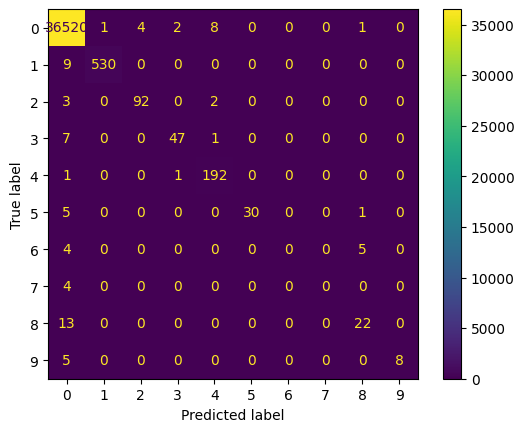

In [ ]:

# clabels = ['AccelY', 'BreakY', 'TurnRightX', 'Turn LeftX', 'PositiveZ', 'NegativeZ', 'GyrPositiveX', 'GyrNegativeX', 'GyrPositiveY', 'GyrNegativeY', 'GyrPositiveZ', 'GyrNegativeZ']

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = clabels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat)
 
# display matrix
cm_display.plot()
plt.show()


## Performance Metrics

- Accuracy = $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class = $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class = $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  

- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [ ]:
# Calculates performance metrics
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')
          
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 99.79%
Precision - Macro: 75.99%
Recall - Macro: 68.53%
F1-score - Macro: 71.64%
Precision - Weighted: 99.76%
Recall - Weighted: 99.79%
F1-score - Weighted: 99.77%


# **TEST THE NETWORK**

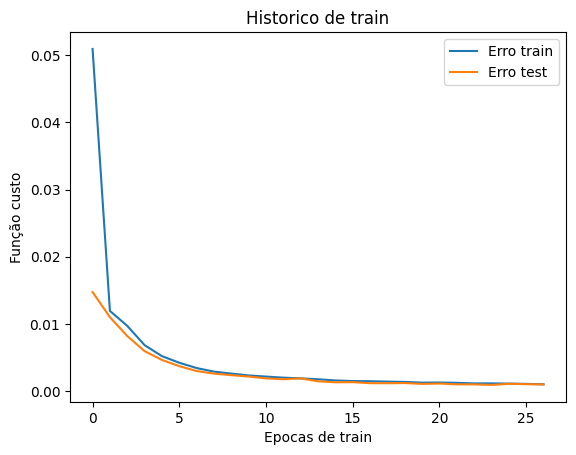

In [ ]:
plt.plot(model_lstm_output.history['loss'])
plt.plot(model_lstm_output.history['val_loss'])
plt.title('Historico de train')
plt.xlabel('Epocas de train')
plt.ylabel('Função custo')
plt.legend(['Erro train', 'Erro test'])
plt.show()

In [ ]:
test[0]
test.shape

(37518, 1, 12)

In [ ]:
i = 0
for i in range(100):
    a = x_test[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model_lstm.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_test[i], decimals=1, out=x_test[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_test[i]) > 0):
      print("X [:", x_test[i])
      print("Y [:", y_test[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
X [: [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.2 0. ]
Y [: 10
PC: [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.7 0. ]]
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━

In [ ]:
test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model_lstm.predict(test_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Value    : [0.    0.363 0.313 0.    0.    0.31  0.393 0.    0.    0.244 0.247 0.   ]
Predicted: [0.12 0.98 0.54 0.07 0.07 0.37 0.3  0.25 0.27 0.37 0.64 0.32]


# **SAVE THE MODEL**

In [ ]:
import os
import datetime

model_name = 'lstm_model_StackedV1_' + datetime.datetime.now().strftime("%Y-%m-%d %HH%Mm%Ss") + '.h5'

# Save the model in runtime_saves/models folder
model_lstm.save(os.path.join(".", 'runtime_saves', 'models', model_name))

In [ ]:
# model sumary
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,238 (391.56 KB)

 Trainable params: 33,412 (130.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,826 (261.04 KB)